In [92]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [93]:
train_A = pd.read_csv("classification_data_HWK1/classificationA.train", header=None, delim_whitespace=True)
N_A = train_A.shape[0]

train_B = pd.read_csv("classification_data_HWK1/classificationB.train", header=None, delim_whitespace=True)
N_B = train_B.shape[0]

train_C = pd.read_csv("classification_data_HWK1/classificationC.train", header=None, delim_whitespace=True)
N_C = train_C.shape[0]

# 1. Generative model (LDA)

In [94]:
epsilon = 0.00001

def mu_hat(train):
    return np.matrix([[sum(train[0] * (1. - train[2])) / sum(1. - train[2]), sum(train[0] * train[2]) / sum(train[2])],
                     [sum(train[1] * (1. - train[2])) / sum((1. - train[2])), sum(train[1] * train[2]) / sum(train[2])]])
# mu_hat_0 = mu_hat[:, 0] (column 0)  
# mu_hat_1 = mu_hat[:, 1] (column 1)  

def pi_hat(train, N):
    return sum(train[2]) / N

def sigma_hat(train, mu_hat, N):
    result = np.zeros((2, 2))
    for i in range(N):
        y_i = int(train[2][i] + epsilon)
        diff = np.matrix([[train[0][i]], [train[1][i]]]) - mu_hat[:, y_i]
        result += diff * diff.transpose()
    result /= N
    return result

mu_hat_A = mu_hat(train_A)
pi_hat_A = pi_hat(train_A, N_A)
sigma_hat_A = sigma_hat(train_A, mu_hat_A, N_A)

mu_hat_B = mu_hat(train_B)
pi_hat_B = pi_hat(train_B, N_B)
sigma_hat_B = sigma_hat(train_B, mu_hat_B, N_B)

mu_hat_C = mu_hat(train_C)
pi_hat_C = pi_hat(train_C, N_C)
sigma_hat_C = sigma_hat(train_C, mu_hat_C, N_C)

In [95]:
def alpha(pi_hat, mu_hat, inv_sigma_hat):
    return (np.log(pi_hat / (1. - pi_hat)) + 1. / 2 * (mu_hat[:, 0] + mu_hat[:, 1]).transpose() * inv_sigma_hat * (mu_hat[:, 0] - mu_hat[:, 1]))[0, 0]

def beta(mu_hat, inv_sigma_hat):
    return (mu_hat[:, 1] - mu_hat[:, 0]).transpose() * inv_sigma_hat

inv_sigma_hat_A = np.linalg.inv(sigma_hat_A)
alpha_A = alpha(pi_hat_A, mu_hat_A, inv_sigma_hat_A)
beta_A = beta(mu_hat_A, inv_sigma_hat_A)

inv_sigma_hat_B = np.linalg.inv(sigma_hat_B)
alpha_B = alpha(pi_hat_B, mu_hat_B, inv_sigma_hat_B)
beta_B = beta(mu_hat_B, inv_sigma_hat_B)

inv_sigma_hat_C = np.linalg.inv(sigma_hat_C)
alpha_C = alpha(pi_hat_C, mu_hat_C, inv_sigma_hat_C)
beta_C = beta(mu_hat_C, inv_sigma_hat_C)

In [96]:
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y, c='blue') 

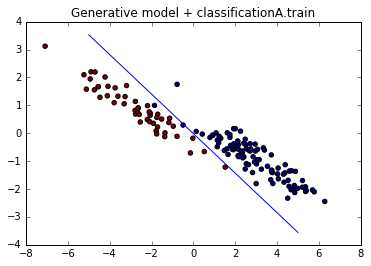

In [141]:
plt.scatter(train_A[0], train_A[1], s = 20, c = train_A[2])    
graph(lambda x: (-alpha_A -beta_A[0, 0] * x) / beta_A[0, 1], range(-5, 6))
plt.title("Generative model + classificationA.train")
plt.show()

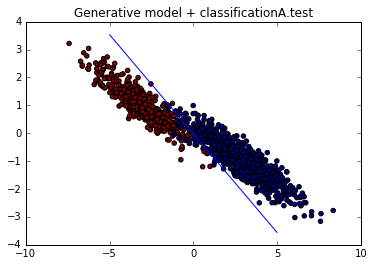

In [146]:
plt.scatter(test_A[0], test_A[1], s = 20, c = test_A[2])    
graph(lambda x: (-alpha_A -beta_A[0, 0] * x) / beta_A[0, 1], range(-5, 6))
plt.title("Generative model + classificationA.test")
plt.show()

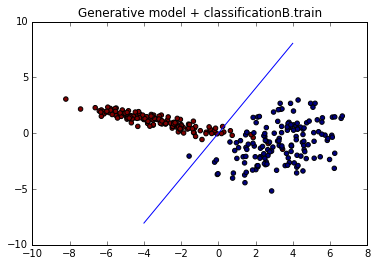

In [98]:
plt.scatter(train_B[0], train_B[1], s = 20, c = train_B[2]) 
graph(lambda x: (-alpha_B -beta_B[0, 0] * x) / beta_B[0, 1], range(-4, 5))
plt.title("Generative model + classificationB.train")
plt.show()

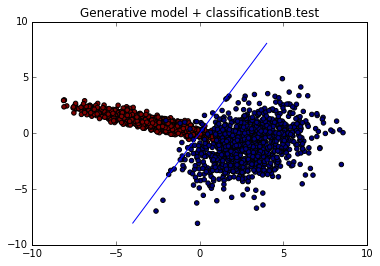

In [145]:
plt.scatter(test_B[0], test_B[1], s = 20, c = test_B[2]) 
graph(lambda x: (-alpha_B -beta_B[0, 0] * x) / beta_B[0, 1], range(-4, 5))
plt.title("Generative model + classificationB.test")
plt.show()

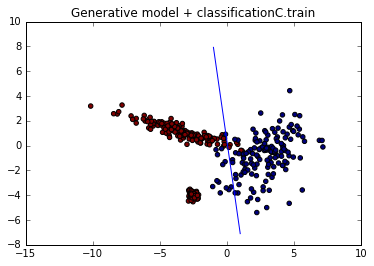

In [99]:
plt.scatter(train_C[0], train_C[1], s = 20, c = train_C[2])
graph(lambda x: (-alpha_C -beta_C[0, 0] * x) / beta_C[0, 1], range(-1, 2))
plt.title("Generative model + classificationC.train")
plt.show()

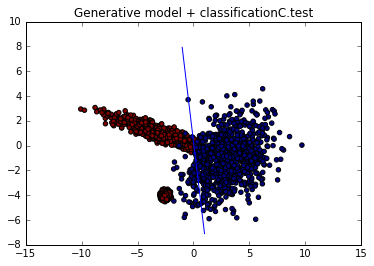

In [144]:
plt.scatter(test_C[0], test_C[1], s = 20, c = test_C[2])
graph(lambda x: (-alpha_C -beta_C[0, 0] * x) / beta_C[0, 1], range(-1, 2))
plt.title("Generative model + classificationC.test")
plt.show()

# 2. Logistic regression

In [100]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def X(train, N):
    result = np.zeros((N, 3))
    for i in range(N):
        result[i][0] = train[0][i]
        result[i][1] = train[1][i]
        result[i][2] = 1.
    return np.matrix(result)

def y(train, N):
    result = np.zeros(N)
    for i in range(N):
        result[i] = train[2][i]
    return np.matrix(result).transpose()
    
def eta(w, X, N):
    result = np.zeros(N)
    for i in range(N):
        result[i] = sigmoid((X[i] * w) [0,0])
    return np.matrix(result).transpose()

def gradl(X, y, eta):
    return X.transpose() * (y - eta)

def Hl(X, eta, N):
    D = np.matrix(np.zeros((N, N)))
    for i in range(N):
        D[i, i] = eta[i, 0] * (1 - eta[i, 0])
    return -X.transpose() * D * X


In [101]:
def IRLS(train, N, n_iter = 100):
    X_temp = X(train, N)
    y_temp = y(train, N)
    w = np.matrix(np.zeros(3)).transpose()
    
    for i in range(n_iter):
        eta_temp = eta(w, X_temp, N)
        w -= np.linalg.solve(Hl(X_temp, eta_temp, N), gradl(X_temp, y_temp, eta_temp))
    
    return w

In [102]:
w_logreg_A = IRLS(train_A, N_A, 500)
w_logreg_B = IRLS(train_B, N_B)
w_logreg_C = IRLS(train_C, N_C)

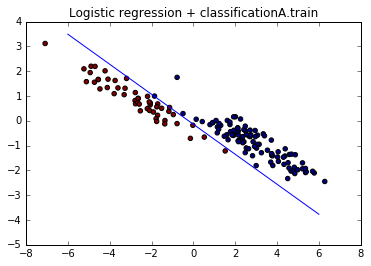

In [151]:
plt.scatter(train_A[0], train_A[1], s = 20, c = train_A[2])    
graph(lambda x: (-w_logreg_A[2, 0] -w_logreg_A[0, 0] * x) / w_logreg_A[1, 0], range(-6, 7))
plt.title("Logistic regression + classificationA.train")
plt.show()

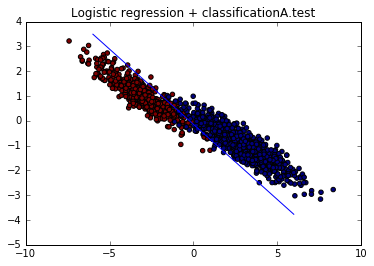

In [150]:
plt.scatter(test_A[0], test_A[1], s = 20, c = test_A[2])    
graph(lambda x: (-w_logreg_A[2, 0] -w_logreg_A[0, 0] * x) / w_logreg_A[1, 0], range(-6, 7))
plt.title("Logistic regression + classificationA.test")
plt.show()

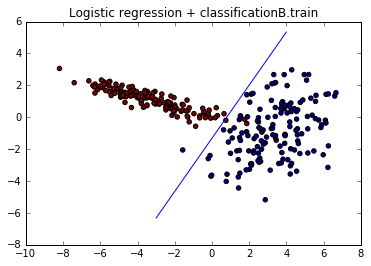

In [154]:
plt.scatter(train_B[0], train_B[1], s = 20, c = train_B[2])    
graph(lambda x: (-w_logreg_B[2, 0] -w_logreg_B[0, 0] * x) / w_logreg_B[1, 0], range(-3, 5))
plt.title("Logistic regression + classificationB.train")
plt.show()

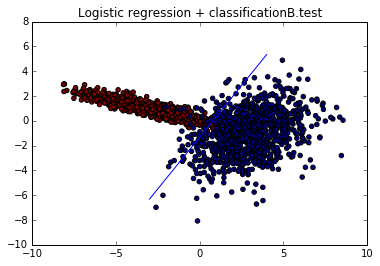

In [153]:
plt.scatter(test_B[0], test_B[1], s = 20, c = test_B[2])    
graph(lambda x: (-w_logreg_B[2, 0] -w_logreg_B[0, 0] * x) / w_logreg_B[1, 0], range(-3, 5))
plt.title("Logistic regression + classificationB.test")
plt.show()

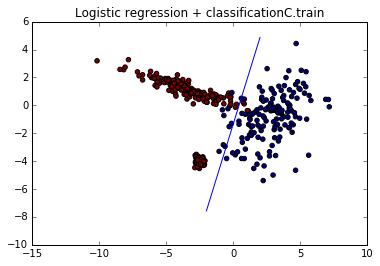

In [106]:
plt.scatter(train_C[0], train_C[1], s = 20, c = train_C[2])    
graph(lambda x: (-w_logreg_C[2, 0] -w_logreg_C[0, 0] * x) / w_logreg_C[1, 0], range(-2, 3))
plt.title("Logistic regression + classificationC.train")
plt.show()

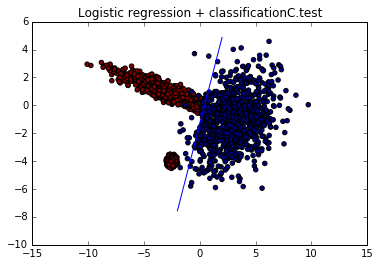

In [155]:
plt.scatter(test_C[0], test_C[1], s = 20, c = test_C[2])    
graph(lambda x: (-w_logreg_C[2, 0] -w_logreg_C[0, 0] * x) / w_logreg_C[1, 0], range(-2, 3))
plt.title("Logistic regression + classificationC.test")
plt.show()

# 3. Linear regression

In [107]:
def linreg(train, N):
    X_temp = X(train, N)
    y_temp = y(train, N)
    return np.linalg.inv(X_temp.transpose() * X_temp) * X_temp.transpose() * y_temp

In [108]:
w_linreg_A = linreg(train_A, N_A)
w_linreg_B = linreg(train_B, N_B)
w_linreg_C = linreg(train_C, N_C)

In [109]:
def var_hat(train, w, N):
    X_temp = X(train, N)
    y_temp = y(train, N)
    result = 0
    for i in range(N):
        temp = y_temp[i, 0] - (w.transpose() * X_temp[i].transpose())[0, 0]
        result += temp * temp
    return result / N

In [110]:
var_hat_A = var_hat(train_A, w_linreg_A, N_A)
var_hat_B = var_hat(train_B, w_linreg_B, N_B)
var_hat_C = var_hat(train_C, w_linreg_C, N_C)

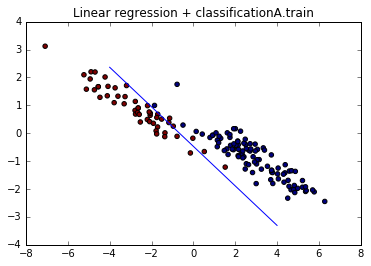

In [111]:
plt.scatter(train_A[0], train_A[1], s = 20, c = train_A[2])    
graph(lambda x: ( 1 - w_linreg_A[2, 0] - np.sqrt(2 * var_hat_A * np.log(np.sqrt(2. / (np.pi * var_hat_A)))) - w_linreg_A[0, 0] * x) / w_linreg_A[1, 0], range(-4, 5))
plt.title("Linear regression + classificationA.train")
plt.show()

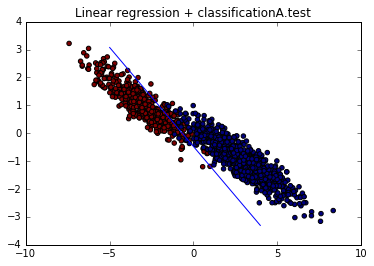

In [157]:
plt.scatter(test_A[0], test_A[1], s = 20, c = test_A[2])    
graph(lambda x: ( 1 - w_linreg_A[2, 0] - np.sqrt(2 * var_hat_A * np.log(np.sqrt(2. / (np.pi * var_hat_A)))) - w_linreg_A[0, 0] * x) / w_linreg_A[1, 0], range(-5, 5))
plt.title("Linear regression + classificationA.test")
plt.show()

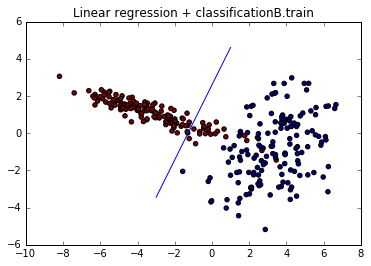

In [112]:
plt.scatter(train_B[0], train_B[1], s = 20, c = train_B[2])    
graph(lambda x: ( 1 - w_linreg_B[2, 0] - np.sqrt(2 * var_hat_B * np.log(np.sqrt(2. / (np.pi * var_hat_B)))) - w_linreg_B[0, 0] * x) / w_linreg_B[1, 0], range(-3, 2))
plt.title("Linear regression + classificationB.train")
plt.show()

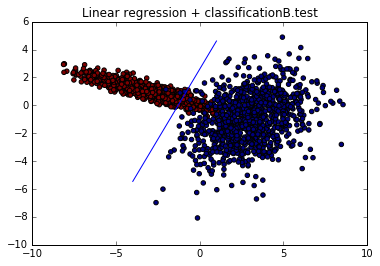

In [159]:
plt.scatter(test_B[0], test_B[1], s = 20, c = test_B[2])    
graph(lambda x: ( 1 - w_linreg_B[2, 0] - np.sqrt(2 * var_hat_B * np.log(np.sqrt(2. / (np.pi * var_hat_B)))) - w_linreg_B[0, 0] * x) / w_linreg_B[1, 0], range(-4, 2))
plt.title("Linear regression + classificationB.test")
plt.show()

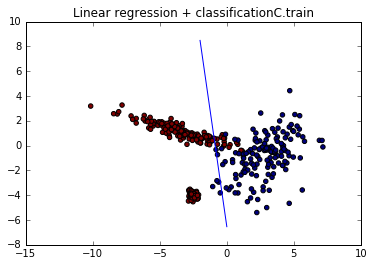

In [113]:
plt.scatter(train_C[0], train_C[1], s = 20, c = train_C[2])    
graph(lambda x: ( 1 - w_linreg_C[2, 0] - np.sqrt(2 * var_hat_C * np.log(np.sqrt(2. / (np.pi * var_hat_C)))) - w_linreg_C[0, 0] * x) / w_linreg_C[1, 0], range(-2, 1))
plt.title("Linear regression + classificationC.train")
plt.show()

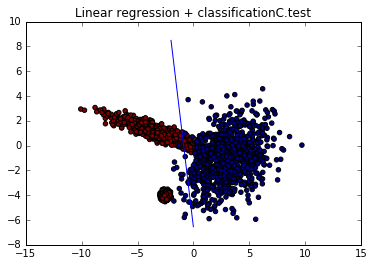

In [160]:
plt.scatter(test_C[0], test_C[1], s = 20, c = test_C[2])    
graph(lambda x: ( 1 - w_linreg_C[2, 0] - np.sqrt(2 * var_hat_C * np.log(np.sqrt(2. / (np.pi * var_hat_C)))) - w_linreg_C[0, 0] * x) / w_linreg_C[1, 0], range(-2, 1))
plt.title("Linear regression + classificationC.test")
plt.show()

# 4. Comparison among different models

In [114]:
test_A = pd.read_csv("classification_data_HWK1/classificationA.test", header=None, delim_whitespace=True)
N_test_A = test_A.shape[0]

test_B = pd.read_csv("classification_data_HWK1/classificationB.test", header=None, delim_whitespace=True)
N_test_B = test_B.shape[0]

test_C = pd.read_csv("classification_data_HWK1/classificationC.test", header=None, delim_whitespace=True)
N_test_C = test_C.shape[0]

In [115]:
def misclassif_rate_gen(data, N, alpha, beta):
    count = 0
    for i in range(N):
        temp = alpha + beta[0, 0] * data[0][i] + beta[0, 1] * data[1][i]
        count += ((temp > 0 and data[2][i] + epsilon < 1) or (temp <= 0 and data[2][i] + epsilon > 1))
    return float(count) / N

In [116]:
misclassif_rate_gen_train_A = misclassif_rate_gen(train_A, N_A, alpha_A, beta_A)
misclassif_rate_gen_train_B = misclassif_rate_gen(train_B, N_B, alpha_B, beta_B)
misclassif_rate_gen_train_C = misclassif_rate_gen(train_C, N_C, alpha_C, beta_C)
misclassif_rate_gen_test_A = misclassif_rate_gen(test_A, N_test_A, alpha_A, beta_A)
misclassif_rate_gen_test_B = misclassif_rate_gen(test_B, N_test_B, alpha_B, beta_B)
misclassif_rate_gen_test_C = misclassif_rate_gen(test_C, N_test_C, alpha_C, beta_C)

In [117]:
def misclassif_rate_logreg(data, N, w):
    count = 0
    for i in range(N):
        temp = w[0, 0] * data[0][i] + w[1, 0] * data[1][i] + w[2, 0]
        count += ((temp > 0 and data[2][i] + epsilon < 1) or (temp <= 0 and data[2][i] + epsilon > 1))
    return float(count) / N

In [118]:
misclassif_rate_logreg_train_A = misclassif_rate_logreg(train_A, N_A, w_logreg_A)
misclassif_rate_logreg_train_B = misclassif_rate_logreg(train_B, N_B, w_logreg_B)
misclassif_rate_logreg_train_C = misclassif_rate_logreg(train_C, N_C, w_logreg_C)
misclassif_rate_logreg_test_A = misclassif_rate_logreg(test_A, N_test_A, w_logreg_A)
misclassif_rate_logreg_test_B = misclassif_rate_logreg(test_B, N_test_B, w_logreg_B)
misclassif_rate_logreg_test_C = misclassif_rate_logreg(test_C, N_test_C, w_logreg_C)

In [119]:
def misclassif_rate_linreg(data, N, w, var):
    count = 0
    for i in range(N):
        temp = 1. / np.sqrt(2 * np.pi * var) * np.exp(- (1 - w[0, 0] * data[0][i] - w[1, 0] * data[1][i] - w[2, 0]) ** 2 / (2 * var))
        count += ((temp > 0.5 and data[2][i] + epsilon < 1) or (temp <= 0.5 and data[2][i] + epsilon > 1))
    return float(count) / N

In [120]:
misclassif_rate_linreg_train_A = misclassif_rate_linreg(train_A, N_A, w_linreg_A, var_hat_A)
misclassif_rate_linreg_train_B = misclassif_rate_linreg(train_B, N_B, w_linreg_B, var_hat_B)
misclassif_rate_linreg_train_C = misclassif_rate_linreg(train_C, N_C, w_linreg_C, var_hat_C)
misclassif_rate_linreg_test_A = misclassif_rate_linreg(test_A, N_test_A, w_linreg_A, var_hat_A)
misclassif_rate_linreg_test_B = misclassif_rate_linreg(test_B, N_test_B, w_linreg_B, var_hat_B)
misclassif_rate_linreg_test_C = misclassif_rate_linreg(test_C, N_test_C, w_linreg_C, var_hat_C)

# 5. QDA model

In [121]:
def sigma_hat_relaxed(train, mu_hat, N):
    result = np.array([np.zeros((2, 2)), np.zeros((2, 2))])
    count = np.zeros(2)
    for i in range(N):
        y_i = int(train[2][i] + epsilon)
        diff = np.matrix([[train[0][i]], [train[1][i]]]) - mu_hat[:, y_i]
        result[y_i] += diff * diff.transpose()
        count[y_i] += 1
    result[0] /= count[0]
    result[1] /= count[1]
    return result

mu_hat_A = mu_hat(train_A)
pi_hat_A = pi_hat(train_A, N_A)
sigma_hat_relaxed_A = sigma_hat_relaxed(train_A, mu_hat_A, N_A)

mu_hat_B = mu_hat(train_B)
pi_hat_B = pi_hat(train_B, N_B)
sigma_hat_relaxed_B = sigma_hat_relaxed(train_B, mu_hat_B, N_B)

mu_hat_C = mu_hat(train_C)
pi_hat_C = pi_hat(train_C, N_C)
sigma_hat_relaxed_C = sigma_hat_relaxed(train_C, mu_hat_C, N_C)

In [122]:
mpl.rcParams['lines.color'] = 'k'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['k'])

x = np.linspace(-9, 9, 400)
y = np.linspace(-5, 5, 400)
x, y = np.meshgrid(x, y)

def axes():
    plt.axhline(0, alpha=.1)
    plt.axvline(0, alpha=.1)
    
# def equation(mu, pi, sigma_relaxed):
#    inv_sigma_relaxed = np.linalg.inv(sigma_relaxed)
#    return lambda x,y: inv_sigma_relaxed[1][0, 0] * (x - mu[0, 1]) ** 2 + (inv_sigma_relaxed[1][1, 0] + inv_sigma_relaxed[1][0, 1]) * (x - mu[0, 1]) * (y - mu[1, 1]) + inv_sigma_relaxed[1][1, 1] * (y - mu[1, 1]) ** 2 - (inv_sigma_relaxed[0][0, 0] * (x - mu[0, 0]) ** 2 + (inv_sigma_relaxed[0][1, 0] + inv_sigma_relaxed[0][0, 1]) * (x - mu[0, 0]) * (y - mu[1, 0]) + inv_sigma_relaxed[0][1, 1] * (y - mu[1, 0]) ** 2) - 2 * np.log(pi / (1 - pi)) 

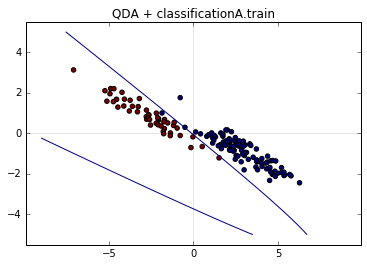

In [123]:
plt.scatter(train_A[0], train_A[1], s = 20, c = train_A[2])    

inv_sigma_relaxed_hat_A = np.linalg.inv(sigma_hat_relaxed_A)
equation_A = inv_sigma_relaxed_hat_A[1][0, 0] * (x - mu_hat_A[0, 1]) ** 2 + (inv_sigma_relaxed_hat_A[1][1, 0] + inv_sigma_relaxed_hat_A[1][0, 1]) * (x - mu_hat_A[0, 1]) * (y - mu_hat_A[1, 1]) + inv_sigma_relaxed_hat_A[1][1, 1] * (y - mu_hat_A[1, 1]) ** 2 - (inv_sigma_relaxed_hat_A[0][0, 0] * (x - mu_hat_A[0, 0]) ** 2 + (inv_sigma_relaxed_hat_A[0][1, 0] + inv_sigma_relaxed_hat_A[0][0, 1]) * (x - mu_hat_A[0, 0]) * (y - mu_hat_A[1, 0]) + inv_sigma_relaxed_hat_A[0][1, 1] * (y - mu_hat_A[1, 0]) ** 2) - 2 * np.log(pi_hat_A / (1 - pi_hat_A)) 

axes()
plt.contour(x, y, equation_A, [0])
plt.title("QDA + classificationA.train")
plt.show()

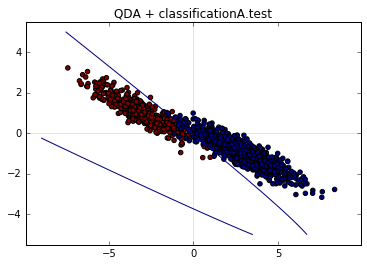

In [124]:
plt.scatter(test_A[0], test_A[1], s = 20, c = test_A[2])    

inv_sigma_relaxed_hat_A = np.linalg.inv(sigma_hat_relaxed_A)
equation_A = inv_sigma_relaxed_hat_A[1][0, 0] * (x - mu_hat_A[0, 1]) ** 2 + (inv_sigma_relaxed_hat_A[1][1, 0] + inv_sigma_relaxed_hat_A[1][0, 1]) * (x - mu_hat_A[0, 1]) * (y - mu_hat_A[1, 1]) + inv_sigma_relaxed_hat_A[1][1, 1] * (y - mu_hat_A[1, 1]) ** 2 - (inv_sigma_relaxed_hat_A[0][0, 0] * (x - mu_hat_A[0, 0]) ** 2 + (inv_sigma_relaxed_hat_A[0][1, 0] + inv_sigma_relaxed_hat_A[0][0, 1]) * (x - mu_hat_A[0, 0]) * (y - mu_hat_A[1, 0]) + inv_sigma_relaxed_hat_A[0][1, 1] * (y - mu_hat_A[1, 0]) ** 2) - 2 * np.log(pi_hat_A / (1 - pi_hat_A)) 

axes()
plt.contour(x, y, equation_A, [0])
plt.title("QDA + classificationA.test")
plt.show()

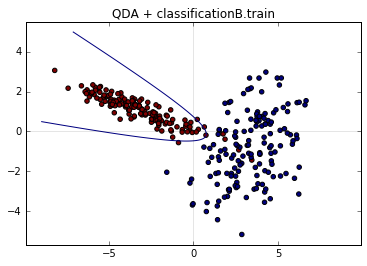

In [125]:
plt.scatter(train_B[0], train_B[1], s = 20, c = train_B[2])    

inv_sigma_relaxed_hat_B = np.linalg.inv(sigma_hat_relaxed_B)
equation_B = inv_sigma_relaxed_hat_B[1][0, 0] * (x - mu_hat_B[0, 1]) ** 2 + (inv_sigma_relaxed_hat_B[1][1, 0] + inv_sigma_relaxed_hat_B[1][0, 1]) * (x - mu_hat_B[0, 1]) * (y - mu_hat_B[1, 1]) + inv_sigma_relaxed_hat_B[1][1, 1] * (y - mu_hat_B[1, 1]) ** 2 - (inv_sigma_relaxed_hat_B[0][0, 0] * (x - mu_hat_B[0, 0]) ** 2 + (inv_sigma_relaxed_hat_B[0][1, 0] + inv_sigma_relaxed_hat_B[0][0, 1]) * (x - mu_hat_B[0, 0]) * (y - mu_hat_B[1, 0]) + inv_sigma_relaxed_hat_B[0][1, 1] * (y - mu_hat_B[1, 0]) ** 2) - 2 * np.log(pi_hat_B / (1 - pi_hat_B)) 

axes()
plt.contour(x, y, equation_B, [0])
plt.title("QDA + classificationB.train")
plt.show()

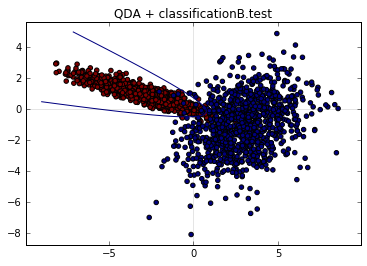

In [126]:
plt.scatter(test_B[0], test_B[1], s = 20, c = test_B[2])    

inv_sigma_relaxed_hat_B = np.linalg.inv(sigma_hat_relaxed_B)
equation_B = inv_sigma_relaxed_hat_B[1][0, 0] * (x - mu_hat_B[0, 1]) ** 2 + (inv_sigma_relaxed_hat_B[1][1, 0] + inv_sigma_relaxed_hat_B[1][0, 1]) * (x - mu_hat_B[0, 1]) * (y - mu_hat_B[1, 1]) + inv_sigma_relaxed_hat_B[1][1, 1] * (y - mu_hat_B[1, 1]) ** 2 - (inv_sigma_relaxed_hat_B[0][0, 0] * (x - mu_hat_B[0, 0]) ** 2 + (inv_sigma_relaxed_hat_B[0][1, 0] + inv_sigma_relaxed_hat_B[0][0, 1]) * (x - mu_hat_B[0, 0]) * (y - mu_hat_B[1, 0]) + inv_sigma_relaxed_hat_B[0][1, 1] * (y - mu_hat_B[1, 0]) ** 2) - 2 * np.log(pi_hat_B / (1 - pi_hat_B)) 

axes()
plt.contour(x, y, equation_B, [0])
plt.title("QDA + classificationB.test")
plt.show()

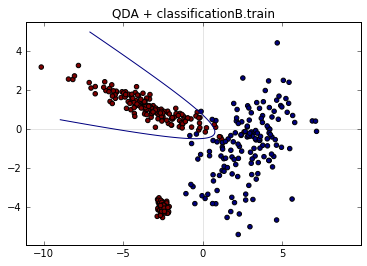

In [127]:
plt.scatter(train_C[0], train_C[1], s = 20, c = train_C[2])    

inv_sigma_relaxed_hat_C = np.linalg.inv(sigma_hat_relaxed_C)
equation_C = inv_sigma_relaxed_hat_C[1][0, 0] * (x - mu_hat_C[0, 1]) ** 2 + (inv_sigma_relaxed_hat_C[1][1, 0] + inv_sigma_relaxed_hat_C[1][0, 1]) * (x - mu_hat_C[0, 1]) * (y - mu_hat_C[1, 1]) + inv_sigma_relaxed_hat_C[1][1, 1] * (y - mu_hat_B[1, 1]) ** 2 - (inv_sigma_relaxed_hat_C[0][0, 0] * (x - mu_hat_C[0, 0]) ** 2 + (inv_sigma_relaxed_hat_C[0][1, 0] + inv_sigma_relaxed_hat_C[0][0, 1]) * (x - mu_hat_C[0, 0]) * (y - mu_hat_C[1, 0]) + inv_sigma_relaxed_hat_C[0][1, 1] * (y - mu_hat_C[1, 0]) ** 2) - 2 * np.log(pi_hat_C / (1 - pi_hat_C)) 

axes()
plt.contour(x, y, equation_B, [0])
plt.title("QDA + classificationB.train")
plt.show()

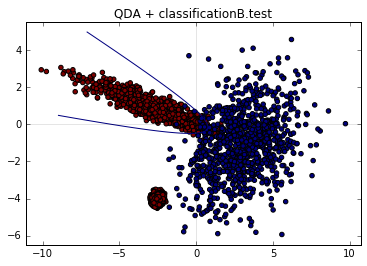

In [128]:
plt.scatter(test_C[0], test_C[1], s = 20, c = test_C[2])    

inv_sigma_relaxed_hat_C = np.linalg.inv(sigma_hat_relaxed_C)
equation_C = inv_sigma_relaxed_hat_C[1][0, 0] * (x - mu_hat_C[0, 1]) ** 2 + (inv_sigma_relaxed_hat_C[1][1, 0] + inv_sigma_relaxed_hat_C[1][0, 1]) * (x - mu_hat_C[0, 1]) * (y - mu_hat_C[1, 1]) + inv_sigma_relaxed_hat_C[1][1, 1] * (y - mu_hat_B[1, 1]) ** 2 - (inv_sigma_relaxed_hat_C[0][0, 0] * (x - mu_hat_C[0, 0]) ** 2 + (inv_sigma_relaxed_hat_C[0][1, 0] + inv_sigma_relaxed_hat_C[0][0, 1]) * (x - mu_hat_C[0, 0]) * (y - mu_hat_C[1, 0]) + inv_sigma_relaxed_hat_C[0][1, 1] * (y - mu_hat_C[1, 0]) ** 2) - 2 * np.log(pi_hat_C / (1 - pi_hat_C)) 

axes()
plt.contour(x, y, equation_B, [0])
plt.title("QDA + classificationB.test")
plt.show()

In [129]:
def misclassif_rate_qda(data, N, mu, pi, sigma):
    inv_sigma = np.linalg.inv(sigma)
    count = 0
    for i in range(N):
        temp = inv_sigma[1][0, 0] * (data[0][i] - mu[0, 1]) ** 2 + (inv_sigma[1][1, 0] + inv_sigma[1][0, 1]) * (data[0][i] - mu[0, 1]) * (data[1][i] - mu[1, 1]) + inv_sigma[1][1, 1] * (data[1][i] - mu[1, 1]) ** 2 - (inv_sigma[0][0, 0] * (data[0][i] - mu[0, 0]) ** 2 + (inv_sigma[0][1, 0] + inv_sigma[0][0, 1]) * (data[0][i] - mu[0, 0]) * (data[1][i] - mu[1, 0]) + inv_sigma[0][1, 1] * (data[1][i] - mu[1, 0]) ** 2) - 2 * np.log(pi / (1 - pi))
        count += ((temp < 0 and data[2][i] + epsilon < 1) or (temp >= 0 and data[2][i] + epsilon > 1))
    return float(count) / N

In [130]:
misclassif_rate_qda_train_A = misclassif_rate_qda(train_A, N_A, mu_hat_A, pi_hat_A, sigma_hat_relaxed_A)
misclassif_rate_qda_train_B = misclassif_rate_qda(train_B, N_B, mu_hat_B, pi_hat_B, sigma_hat_relaxed_B)
misclassif_rate_qda_train_C = misclassif_rate_qda(train_C, N_C, mu_hat_C, pi_hat_C, sigma_hat_relaxed_C)
misclassif_rate_qda_test_A = misclassif_rate_qda(test_A, N_A, mu_hat_A, pi_hat_A, sigma_hat_relaxed_A)
misclassif_rate_qda_test_B = misclassif_rate_qda(test_B, N_B, mu_hat_B, pi_hat_B, sigma_hat_relaxed_B)
misclassif_rate_qda_test_C = misclassif_rate_qda(test_C, N_C, mu_hat_C, pi_hat_C, sigma_hat_relaxed_C)